# Supervised Classification

Now that our customer segmentation is done, we will build a model able to predict to which cluster a customer belong based on purchase data

We will compare performances of SVM, RandomForest and GradientBoosting algorithms

In [18]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import timeit

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA  
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# Input data: processing

In [20]:
## data after feature engineering
CustomerTable_fin = pd.read_csv('CustomerTable_fin.csv',index_col=0)
### log-scaled data
Scaled_CustomerTable = pd.read_csv('Scaled_CustomerTable.csv',index_col=0)

In [21]:
from joblib import dump, load
# group labels
df_labels = load('df_labels_fin.pkl')

### split

For every model we will use the same split of the data: 25% into test data and stratified to keep similar proportions of each cluster into the two split train and test

In [13]:
from sklearn.model_selection import train_test_split

X = Scaled_CustomerTable
y = df_labels['label_names']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=100, stratify=y)
    #stratify pour garder même proportions de y

We will work on the PCA-transformed data but to avoid any data leakage between test and train subsets we integrate scaling and pca computations into a pipeline (sklearn.pipeline) that will be applied on each split independently.

`pipe = Pipeline([('scaler', StandardScaler()),
                 ('PCA', PCA(n_components=8)),
                 ('model',Model_lambda())
                 ])`

# Dummy classifier

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn import dummy
from sklearn.metrics import accuracy_score


pipe = Pipeline([('scaler', StandardScaler()),
                 ('PCA', PCA(n_components=8)),
                 ('Dummy',dummy.DummyClassifier())
                ])
pipe.fit(X_train, y_train)

param_grid = {
    'Dummy__strategy': ['stratified','most_frequent','uniform']
}

# Instantiate the grid search model
grid_dum = GridSearchCV(estimator = pipe, param_grid = param_grid, cv=5)
# Fit the grid search to the data
grid_dum.fit(X_train,y_train)
print(grid_dum.best_params_)


y_true, y_pred = y_test, grid_dum.predict(X_test) 
out_accuracy = accuracy_score(y_true, y_pred)
print(out_accuracy)

{'Dummy__strategy': 'most_frequent'}
0.4246119733924612


We can choose among different options for the dummy classifier. Here the best result is obtained with the classifier predicting always the most frequent group. His accuracy (~0.42) will serve as a point of comparison for the other models.

# RandomForest

We create a paramater grid to try different values for the hyperparameters
The metric used to assess the accuracy is the Kappa score and will guide the optimization process

In [7]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, make_scorer, accuracy_score

def Rforest_cv(X_train, y_train):
    
    start_time = timeit.default_timer()

    pipe = Pipeline([('scaler', StandardScaler()),
                     ('PCA', PCA(n_components=8)),
                     ('RForest',RandomForestClassifier(random_state=10))
                    ])
    pipe.fit(X_train, y_train)

    # Create the parameter grid based on the results of random search 
    param_grid = {
        'RForest__max_depth': [30, 40, 60, None],
        'RForest__max_features': [2, 3, 4],
        'RForest__n_estimators': [500, 800, 1000]
    }

    kappa_scorer = make_scorer(cohen_kappa_score)
    cv = StratifiedKFold(n_splits=5, shuffle=False, random_state=0)

    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring=kappa_scorer,
                              cv = cv, n_jobs = -1, verbose = 2)
    # Fit the grid search to the data
    grid_search.fit(X_train,y_train)
    print(grid_search.best_params_)

    elapsed = timeit.default_timer() - start_time
    print(elapsed)

    y_true, y_pred = y_test, grid_search.predict(X_test)
    out_accuracy = accuracy_score(y_true, y_pred)
    print('Accuracy: ',out_accuracy)

Rforest_cv(X_train, y_train)

C:\Users\Nicolas\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


{'RForest__max_depth': 30, 'RForest__max_features': 4, 'RForest__n_estimators': 800}
152.8070625106667
Accuracy:  0.9567627494456763


The best accuracy reached by RandomForest is ~0.96 with
- 'RForest__max_depth': 30
- 'RForest__max_features': 4
- 'RForest__n_estimators': 800

# SVM

We use the same procedure for the SVC model

In [16]:
from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, make_scorer, accuracy_score

def SVM_cv(X_train, y_train):
    
    start_time = timeit.default_timer()

    pipe = Pipeline([('scaler', StandardScaler()),
                     ('PCA', PCA(n_components=8)),
                     ('SVM',LinearSVC(max_iter=10000, dual=False))
                    ])
    pipe.fit(X_train, y_train)

    # Create the parameter grid based on the results of random search 
    param_grid = {'SVM__C': np.logspace(-3,3,10) }

    kappa_scorer = make_scorer(cohen_kappa_score)
    cv = StratifiedKFold(n_splits=5, shuffle=False, random_state=0)

    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring=kappa_scorer,
                              cv = cv, n_jobs = -1, verbose = 2)
    # Fit the grid search to the data
    grid_search.fit(X_train,y_train)
    print(grid_search.best_params_)

    elapsed = timeit.default_timer() - start_time
    print(elapsed)

    y_true, y_pred = y_test, grid_search.predict(X_test)
    out_accuracy = accuracy_score(y_true, y_pred)
    print('Accuracy: ',out_accuracy)

SVM_cv(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    5.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.6s finished


{'SVM__C': 10.0}
6.136775945262343
Accuracy:  0.9434589800443459


The best accuracy reached by SVC model is ~0.94 with
- parameter C: 10.0

# Gradient Boosting

For the GradientBoosting model we will use a "stump" (a simple decision tree with only one level) as a weak learner ('max_depth' set to one)
In the parameter grid we will explore different values for numbers of learners and learning rate

In [10]:
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, make_scorer, accuracy_score

def GBoost_cv(X_train, y_train):
    
    start_time = timeit.default_timer()

    pipe = Pipeline([('scaler', StandardScaler()),
                     ('PCA', PCA(n_components=8)),
                     ('GBoost',GradientBoostingClassifier(max_depth=1, random_state=0))
                    ])
    pipe.fit(X_train, y_train)

    # Create the parameter grid based on the results of random search 
    param_grid = {'GBoost__n_estimators': [500, 1000],
                  'GBoost__learning_rate': [0.1,1.0]                 
                 }

    kappa_scorer = make_scorer(cohen_kappa_score)
    cv = StratifiedKFold(n_splits=5, shuffle=False, random_state=0)

    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring=kappa_scorer,
                              cv = cv, n_jobs = -1, verbose = 2)
    # Fit the grid search to the data
    grid_search.fit(X_train,y_train)
    print(grid_search.best_params_)

    elapsed = timeit.default_timer() - start_time
    print(elapsed)

    y_true, y_pred = y_test, grid_search.predict(X_test)
    out_accuracy = accuracy_score(y_true, y_pred)
    print('Accuracy: ',out_accuracy)
    
    return(grid_search)

model = GBoost_cv(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   26.5s finished


{'GBoost__learning_rate': 0.1, 'GBoost__n_estimators': 1000}
34.14533722247222
Accuracy:  0.9778270509977827


The best accuracy reached by GradientBoosting model is ~0.98 with
- 'GBoost__learning_rate': 0.1
- 'GBoost__n_estimators': 1000

After model fitting and hyperparameter selection:

- RandomForest accuracy 0.957
- SVC accuracy          0.939
- GradientBoosting acc. 0.978

GradientBoosting model had the best performances we keep this model.

In [11]:
dump(model,'GBref_model.pkl')

['GBref_model.pkl']

### Nested Cross-Validation

I want to try an algorithm of 'nested cross-validation' to assess how the performances of the model change when the test fold changes.

We start with the whole datatset. 
At each rotation, one fold (10%) is assigned to test, 9 other folds are used for the cross-validation procedure (one validation fold and 8 folds for training). At the end of each of the ten rotations, the model with the best validation score is assessed on the test set.

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA   
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import cohen_kappa_score, make_scorer, accuracy_score
import timeit

### data used for algorithm
XX = X
yy = y
n_folds = 10
verbose = False
start_time = timeit.default_timer()

outer_cv = StratifiedKFold(n_splits=n_folds, random_state=42)
inner_cv = StratifiedKFold(n_splits=n_folds-1, random_state=42)
scorer = make_scorer(cohen_kappa_score)

pipe = Pipeline([('scaler', StandardScaler()),
                 ('PCA', PCA(n_components=8)),
                 ('GBoost',GradientBoostingClassifier(max_depth=1,random_state=0))
                ])

# Create the parameter grid based on the results of random search 
param_grid = {'GBoost__n_estimators': [500,1000],
              'GBoost__learning_rate': [0.1,1]             
             }

result = pd.DataFrame()
evaluation = pd.DataFrame()
n_rotation = 1
print('Nested Cross-Validation on {}-folds dataset (split train-validation-test) \n'.format(n_folds))
#outer loop - n_folds loops
for train_index, test_index in outer_cv.split(XX, yy):
    X_train, X_test = XX.iloc[train_index], XX.iloc[test_index]
    y_train, y_test = yy.iloc[train_index], yy.iloc[test_index]
    
    pipe.fit(X_train,y_train)
    model = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=inner_cv, scoring=scorer)
    model.fit(X_train, y_train)
    
    result = pd.concat([result,
                       pd.DataFrame([model.best_params_.values()],
                                    columns=model.best_params_.keys(),
                                   index=[n_rotation])])
    y_true, y_pred = y_test, model.predict(X_test)
    dict_eval = {'best validation score': model.best_score_,
                 'accuracy (test)': accuracy_score(y_true, y_pred),
                 'Kappa (test)': cohen_kappa_score(y_true, y_pred)
                }
    evaluation = pd.concat([evaluation,
                           pd.DataFrame([dict_eval.values()],
                                    columns=dict_eval.keys(),
                                   index=[n_rotation])])
    print('Rotation ',n_rotation)
    if verbose:
        print('best model parameters: ',model.best_params_)
        for key in dict_eval.keys():
            print(key,': ',dict_eval[key])
        print('***********************')
        print('\n')
    n_rotation+=1

display(evaluation.groupby([result['GBoost__learning_rate'],result['GBoost__n_estimators']]).agg({
    'best validation score': ['max','mean',lambda x: len(x)],
    'accuracy (test)': ['max', 'mean','std'],
    'Kappa (test)': ['max', 'mean','std']
}))
elapsed = timeit.default_timer() - start_time
print('elapsed time: ',elapsed)

Nested Cross-Validation on 10-folds dataset (split train-validation-test) 

Rotation  1
Rotation  2
Rotation  3
Rotation  4
Rotation  5
Rotation  6
Rotation  7
Rotation  8
Rotation  9
Rotation  10


best validation score            \
                                                             max      mean   
GBoost__learning_rate GBoost__n_estimators                                   
0.1                   500                               0.960701  0.959677   
                      1000                              0.965460  0.959001   

                                                    accuracy (test)            \
                                           <lambda>             max      mean   
GBoost__learning_rate GBoost__n_estimators                                      
0.1                   500                       2.0        0.963989  0.958578   
                      1000                      8.0        0.991643  0.971893   

                                                     Kappa (test)            \
                                                 std          max      mean   
GBoost__learning_rate GBoost__n_estimators                                    
0.1                   500                   0.007652     0.950776  0.943315   
                      1000                  0.012909     0.988567  0.961567   

                                                      
                                                 std  
GBoost__learning_rate GBoost__n_estimators            
0.1                   500                   0.010551  
                      1000                  0.017621

elapsed time:  1781.1527277240777


Out of the 10 rotations, the model {learning_rate:0.1, n_estimators:1000} obtained the best performance 8 times. His performance on the test set is:
- Mean Accuracy 0.972 (+/- 0.0129 SD)
- Mean Cohen's Kappa 0.962 (+/- 0.0176 SD)

Nested cross-validation algorithms are known to give rather optimistic evaluation of performance. Here, this procedure is used to gain a higher level of confidence in the choice of the final hyperparmater values. I will repeat the procedure with a 0.2 learning rate value.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA   
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import cohen_kappa_score, make_scorer, accuracy_score
import timeit

### data used for algorithm
XX = X
yy = y
n_folds = 10
verbose = False
start_time = timeit.default_timer()

outer_cv = StratifiedKFold(n_splits=n_folds, random_state=42)
inner_cv = StratifiedKFold(n_splits=n_folds-1, random_state=42)
scorer = make_scorer(cohen_kappa_score)

pipe = Pipeline([('scaler', StandardScaler()),
                 ('PCA', PCA(n_components=8)),
                 ('GBoost',GradientBoostingClassifier(max_depth=1, n_estimators=1000,
                                                      random_state=0))
                ])

# Create the parameter grid based on the results of random search 
param_grid = {'GBoost__learning_rate': [0.01, 0.1, 0.2, 1]  }

result = pd.DataFrame()
evaluation = pd.DataFrame()
n_rotation = 1
print('Nested Cross-Validation on {}-folds dataset (split train-validation-test) \n'.format(n_folds))
#outer loop - n_folds loops
for train_index, test_index in outer_cv.split(XX, yy):
    X_train, X_test = XX.iloc[train_index], XX.iloc[test_index]
    y_train, y_test = yy.iloc[train_index], yy.iloc[test_index]
    
    pipe.fit(X_train,y_train)
    model = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=inner_cv, scoring=scorer)
    model.fit(X_train, y_train)
    
    result = pd.concat([result,
                       pd.DataFrame([model.best_params_.values()],
                                    columns=model.best_params_.keys(),
                                   index=[n_rotation])])
    y_true, y_pred = y_test, model.predict(X_test)
    dict_eval = {'best validation score': model.best_score_,
                 'accuracy (test)': accuracy_score(y_true, y_pred),
                 'Kappa (test)': cohen_kappa_score(y_true, y_pred)
                }
    evaluation = pd.concat([evaluation,
                           pd.DataFrame([dict_eval.values()],
                                    columns=dict_eval.keys(),
                                   index=[n_rotation])])
    print('Rotation ',n_rotation)
    if verbose:
        print('best model parameters: ',model.best_params_)
        for key in dict_eval.keys():
            print(key,': ',dict_eval[key])
        print('***********************')
        print('\n')
    n_rotation+=1

display(evaluation.groupby([result['GBoost__learning_rate']]).agg({
    'best validation score': ['max','mean',lambda x: len(x)],
    'accuracy (test)': ['max', 'mean','std'],
    'Kappa (test)': ['max', 'mean','std']
}))
elapsed = timeit.default_timer() - start_time
print('elapsed time: ',elapsed)

In [11]:
display(evaluation.groupby([result['GBoost__learning_rate']]).agg({
    'best validation score': ['max','mean',lambda x: len(x)],
    'accuracy (test)': ['max', 'mean','std'],
    'Kappa (test)': ['max', 'mean','std']
}))

best validation score                     \
                                        max      mean <lambda>   
GBoost__learning_rate                                            
0.1                                0.961260  0.958383      8.0   
0.2                                0.965048  0.960196      2.0   

                      accuracy (test)                     Kappa (test)  \
                                  max      mean       std          max   
GBoost__learning_rate                                                    
0.1                          0.988889  0.971261  0.010090     0.984766   
0.2                          0.963889  0.959722  0.005893     0.950582   

                                           
                           mean       std  
GBoost__learning_rate                      
0.1                    0.960718  0.013792  
0.2                    0.944896  0.008042

After repeating the procedure, the model with 0.1 learning rate is still the best model.

### Repeated Randomized split test/train to assess variance of model performance

The 3 models (RForest, SVC, GBoosting), were trained on a 0.75/0.25 train/test split of the data fixed with the seed random_state=100

The performance can change slightly with the random seed used. We will repeat the tarining procedure 100 times with different seeds to to assess the range of variation

In [22]:
from sklearn.model_selection import train_test_split
start_time = timeit.default_timer()
pipe_gb = Pipeline([('scaler', StandardScaler()),('PCA', PCA(n_components=8)),
                 ('GBoost',GradientBoostingClassifier(max_depth=1, random_state=0,
                                                      learning_rate=0.1, n_estimators=1000))
                    ])
pipe_rf = Pipeline([('scaler', StandardScaler()),('PCA', PCA(n_components=8)),
                 ('GBoost',RandomForestClassifier(max_depth=30, random_state=10,
                                                      max_features=4, n_estimators=800))
                    ])
pipe_svc = Pipeline([('scaler', StandardScaler()),('PCA', PCA(n_components=8)),
                 ('GBoost',LinearSVC(C=10, dual=False, max_iter=10000))
                    ])
res_gb = []
res_rf = []
res_svc = []
for i in np.random.randint(1000, size=100):
    
    ## split data (random_state, test_size, stratify =[y,None])    
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.25,
                                                        random_state=i, stratify=y)
    pipe_gb.fit(X_train2,y_train2)
    pipe_rf.fit(X_train2,y_train2)
    pipe_svc.fit(X_train2,y_train2)
    
    res_gb.extend([accuracy_score(y_test2, pipe_gb.predict(X_test2))])
    res_rf.extend([accuracy_score(y_test2, pipe_rf.predict(X_test2))])
    res_svc.extend([accuracy_score(y_test2, pipe_svc.predict(X_test2))])
print('elapsed: ', timeit.default_timer() - start_time)
print('mean GB accuracy (+-SD): {}(+-{})'.format(round(np.mean(res_gb),3),round(np.std(res_gb),4)))
print('mean RF accuracy (+-SD): {}(+-{})'.format(round(np.mean(res_rf),3),round(np.std(res_rf),4)))
print('mean SVC accuracy (+-SD): {}(+-{})'.format(round(np.mean(res_svc),3),round(np.std(res_svc),4)))

elapsed:  1171.9756579212758
mean GB accuracy (+-SD): 0.969(+-0.0056)
mean RF accuracy (+-SD): 0.959(+-0.0073)
mean SVC accuracy (+-SD): 0.951(+-0.0077)


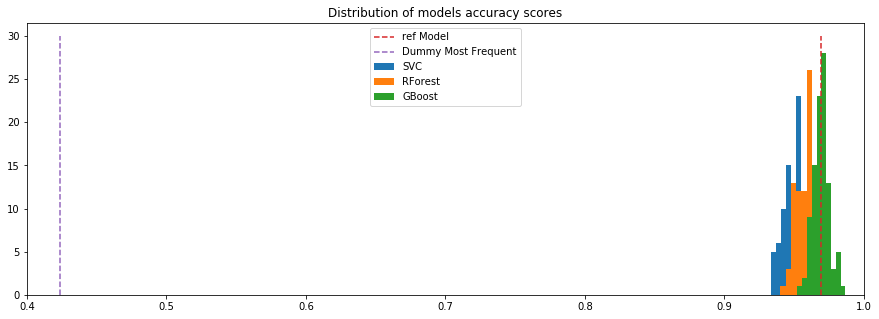

In [25]:
plt.figure(figsize = (15,5))
plt.hist(res_svc,bins=10, label= 'SVC')
plt.hist(res_rf,bins=10, label='RForest')
plt.hist(res_gb,bins=10, label='GBoost')

plt.plot([0.969]*2,[0,30],ls='--', label='ref Model')
plt.plot([0.42350332594235035]*2,[0,30],ls='--', label='Dummy Most Frequent')
plt.legend(loc='upper center')
plt.xlim(0.4,1)
plt.title('Distribution of models accuracy scores')
plt.show()

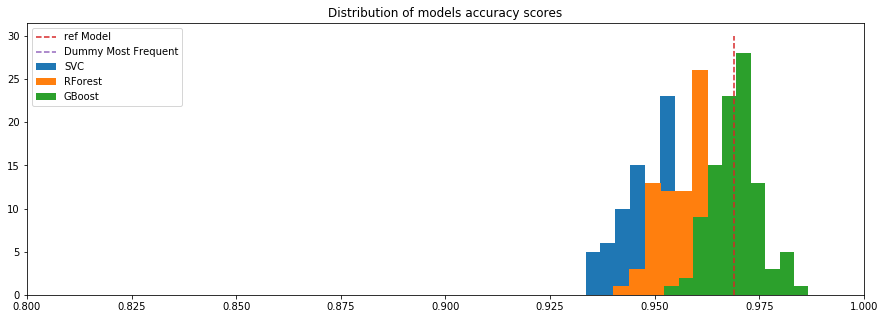

In [26]:
bb = 10

plt.figure(figsize = (15,5))
plt.hist(res_svc, bins=bb, label= 'SVC')
plt.hist(res_rf,bins=bb, label='RForest')
plt.hist(res_gb,bins=bb, label='GBoost')

plt.plot([0.9689578713968958]*2,[0,30],ls='--', label='ref Model')
plt.plot([0.42350332594235035]*2,[0,30],ls='--', label='Dummy Most Frequent')
plt.legend()
plt.xlim(0.8,1)
plt.title('Distribution of models accuracy scores')
plt.show()

### Confusion Matrix

Finally we compute the confusion matrix to display how the potential errors of predictions are distributed amon categories

In [ ]:
## split initial
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=100, stratify=y)

Confusion matrix, without normalization
[[ 91   0   1   0   0]
 [  0 157   3   1   2]
 [  1   0 381   1   0]
 [  2   0   7 151   1]
 [  0   1   0   0 102]]


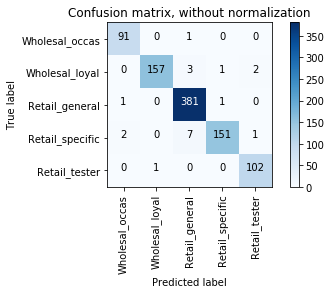

In [28]:
from utils import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

model = load('GBref_model.pkl')
y_true, y_pred = y_test, model.predict(X_test)
cmat1 = confusion_matrix(y_true, y_pred, labels=df_labels['label_names'].unique())

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cmat1, classes=df_labels['label_names'].unique(),
                      title='Confusion matrix, without normalization')

The predictive power of the GradientBoosting model is quite satisfying

In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

                    precision    recall  f1-score   support

  Det_generalistes       0.97      0.99      0.98       382
   Det_specifiques       0.97      0.95      0.96       161
      Det_testeurs       0.96      0.94      0.95       103
     Gross_fideles       0.97      0.96      0.97       163
Gross_occasionnels       0.96      0.97      0.96        93

       avg / total       0.97      0.97      0.97       902

